# **Data Preprocessing**

### **Student Identification**

Student Name       | Student Email
-------------------|------------------
Daniel Branco      | r20191230@novaims.unl.pt
Filipe Dias        | r20181050@novaims.unl.pt
Gonçalo Lourenço   | r20191097@novaims.unl.pt
Inês Santos        | r20191184@novaims.unl.pt
Manuel Marreiros   | r20191223@novaims.unl.pt

### **Data Source**

Brain Tumor Classification (MRI) Dataset: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

Drive with data: https://drive.google.com/file/d/1P3hcUss5Kqb28_WQUcTsuTW2VjNTX4pd/view?usp=share_link

### **Notebook Summary**

In this notebook, we do some preprocessing steps in our dataset which will be useful later when we define the models.

As aforementioned, at this stage the imbalance of our classes has been handled. 

Not only that, we also defined rescaling and batch normalization layers, which will be included later in the models. We have created both these layers to be able to analyse which of them suits our needs better, and a bigger comparison between the two is made below.

Lastly, a augmentation pipeline was created to also be applied later on. 

### **Imports**

In [ ]:
pip install keras-tuner tensorflow-addons --quiet

In [ ]:
import os
import time
import math
import random 
import zipfile
import shutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, Model, layers, initializers, regularizers, optimizers, metrics 
from tensorflow.keras.initializers import GlorotNormal
import tensorflow_addons as tfa

import keras
from keras_tuner import Objective
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

### **Things needed from previous notebook**

In [ ]:
#EXPLORATION

# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/Deep Learning/Projeto/"
main_folder, training_folder, testing_folder = "brain_tumor_data/", "Training/", "Testing/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'brain_tumor_data.zip', 'brain_tumor_data.zip')
    # Extract files
    zip_ = zipfile.ZipFile('brain_tumor_data.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

classes = ["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"]

# Create empty lists to store the number of instances and class names
n_train = []
class_names = []

# Loop through each class in the dataset
for c in classes:
    # Get the number of instances in the training set for the current class
    n_train_c = len(os.listdir(path + main_folder + training_folder + f"/{c}"))
    # Append the number of instances and class name to their respective lists
    n_train.append(n_train_c)
    class_names.append(c)

image_size=(128, 128)
crop_to_aspect_ratio=True
color_mode='grayscale'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)

iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File transfer completed in 2.816 seconds
Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Using 574 files for validation.


### **Defining Class Weights**

By creating class weights for each of the four classes, no_tumor will have a higher weight associated to it, which means that once we fit the model and pass the weights as arguments we won't be neglecting this minority class.

In [ ]:
n_classes = len(classes)
total_samples = np.sum(n_train)

class_weights = {}
for i in range(n_classes):
    w = total_samples / (2.0 * n_train[i])
    class_weights[i] = w

print('Class counts:', n_train)
print('Class weights:', class_weights)

Class counts: [395, 826, 822, 827]
Class weights: {0: 3.632911392405063, 1: 1.7372881355932204, 2: 1.745742092457421, 3: 1.735187424425635}


### **Preprocessing Layers**

These layers are to be used in the model handcraft stage at our will. We will experiment both of them, in different combinations, and see which one gives us the best overal results.

In [ ]:
input_shape = tuple(batch_x_train.shape)
rescaling = layers.Rescaling(1./255)
batchnormalization = layers.BatchNormalization()

layers.Rescaling(1./255) is a simple form of preprocessing that scales the pixel values of the input images to a range of 0 to 1. This is often used in image classification tasks where the pixel values are large and can vary widely, which can make it difficult for the model to learn. By scaling the pixel values to a smaller range, the model can more easily learn the patterns and relationships between the pixels.

layers.BatchNormalization(), on the other hand, is a more complex form of preprocessing that normalizes the activations of the previous layer. This can improve the stability of the model and reduce the likelihood of overfitting by ensuring that the input values are not too large or too small. Batch normalization is particularly useful for deep neural networks with many layers, where the activations can become unstable and cause problems with training.

### **Data Augmentation**



By training models on numerous significantly changed copies of existing data, data augmentation is a strategy used to avoid overfitting while training a machine learning model. Below we are defining our augmentation pipeline, where we use rotations, different zooms, different contrasts, and more.

We have decided not to use all augmentation layers, because due to the "specific" nature of our images, having very agressive augmentations was heavily decreasing the performance of the models.

In [ ]:
rotation_layer = layers.RandomRotation(factor=0.05)
zoom_layer = layers.RandomZoom(height_factor=0.05, width_factor=0.05)
contrast_layer = layers.RandomContrast(factor=0.10)
brightness_layer = layers.RandomBrightness(factor=0.05)
noise_layer = layers.GaussianNoise(0.05)
flip_layer = layers.RandomFlip(mode='horizontal')
crop_layer = layers.RandomCrop(height=300, width=300)
translation_layer = layers.RandomTranslation(height_factor=0.1, width_factor=0.1)

def augmentation(inputs):
    x = rotation_layer(inputs)
    x = zoom_layer(x)
    x = contrast_layer(x)
    x = brightness_layer(x)
    x = noise_layer(x)
    return x

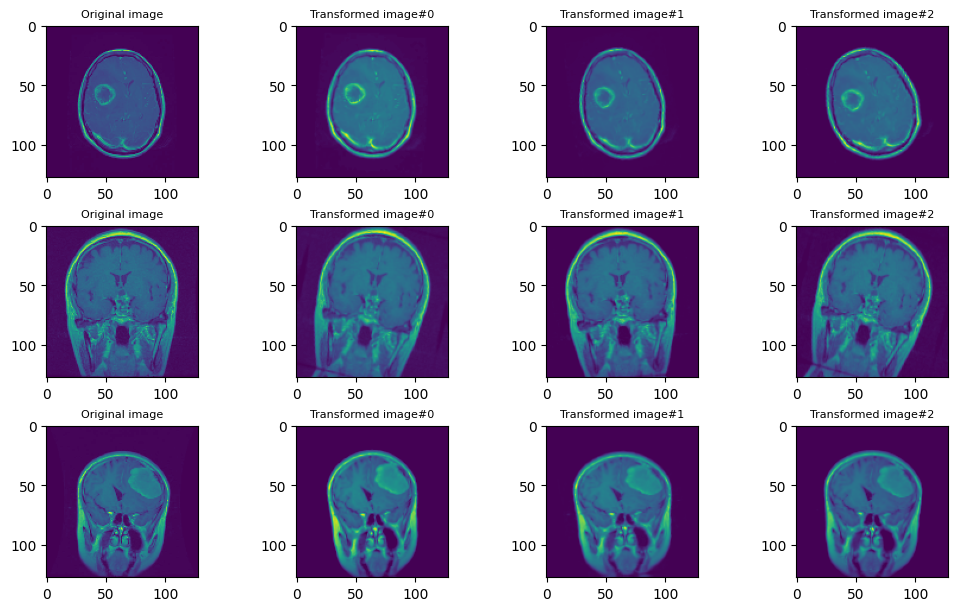

In [ ]:
def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=3, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation(img)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)

show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=augmentation)